## Train Classifier: BERT

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_from_disk
from sklearn.metrics import accuracy_score
import random
import numpy as np
import torch
import os

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
topic = "energie" #"energie" #"kinder" "cannabis"

## Load Dataset

In [3]:
dataset = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_chunkified_random_384")

In [4]:
# dataset_holdout = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_chunkified_random_holdout")

# #Shuffle the dataset
# dataset_holdout = dataset_holdout.shuffle(seed=42)

# #Sample 6_000 random examples
# num_samples = 5_000
# dataset_holdout = dataset_holdout.select(range(num_samples))

# from datasets import concatenate_datasets
# dataset["train"] = concatenate_datasets([dataset["train"], dataset_holdout])
# dataset["train"] = dataset["train"].shuffle(seed=42)

In [5]:
# Sample 100 random indices from the training dataset
#random_indices = random.sample(range(len(dataset['train'])), 100)

# Select 100 examples from the training dataset
#dataset['train'] = dataset['train'].select(random_indices)

In [6]:
# Explore the dataset
print(dataset)
print(dataset['train'][1]) 

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id'],
        num_rows: 3398
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id'],
        num_rows: 478
    })
})
{'_id': '64a0946d749484eec855d4bb', 'batch_id': 16, 'domain': 't-online.de', 'view_url': 'email.t-online.de/em#f=INBOX&m=15411876806784410&method=showReadmail', 'lang': 'de', 'text': '. Bundesliga Zweikampf der Woche Fußball Champions League FC Bayern Newsticker Formel 1 Was macht …', 'text_length': 99, 'word_count': 16, 'topic': 'energie', 'category': 'other', 'good_for_training': 'True', 'good_for_

## Prepare Data

In [7]:
MODEL_NAME = "deepset/gbert-large"

In [8]:
# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [9]:
# Tokenize the text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/478 [00:00<?, ? examples/s]

Map: 100%|██████████| 478/478 [00:00<00:00, 2569.41 examples/s]


## Prepare Model

In [10]:
# Load a pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train Model

In [11]:

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}


In [12]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,             # number of training epochs
    weight_decay=0.01,  # Weight decay if we apply some form of weight regularization.
    logging_dir='./logs',  # Directory where the training logs will be stored.
    logging_strategy="steps",  # The logging strategy determines when to log
    logging_steps=100,  # Number of steps between logging of training loss.
    evaluation_strategy="steps",  # Evaluation is done
    eval_steps=100,  # Number of steps between evaluations.
    load_best_model_at_end=True,  # load the best model at the end of training.
    metric_for_best_model="eval_loss",
    lr_scheduler_type='linear',  # The scheduler type to use, e.g., 'linear', 'cosine'
    warmup_ratio=0.1  # Proportion of training to perform linear learning rate warmup for.
)

In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights inversely proportional to class frequencies
labels = tokenized_datasets["train"]['label']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights_tensor)

Class weights: tensor([1.0241, 0.9770])


In [14]:
from torch import nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [15]:
from transformers import EarlyStoppingCallback

# Create a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [16]:
# Train the model
trainer.train()

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
100,0.525700,0.349846,0.853556
200,0.304700,0.111291,0.970711
300,0.267200,0.096688,0.972803
400,0.279700,0.197961,0.945607
500,0.199800,0.137178,0.972803
600,0.152100,0.101087,0.983264
700,0.173300,0.145805,0.976987
800,0.177200,0.076826,0.981172
900,0.123900,0.100465,0.976987
1000,0.079900,0.162827,0.966527


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jschelb/.pyenv/v

TrainOutput(global_step=2000, training_loss=0.13974343490600585, metrics={'train_runtime': 2513.3506, 'train_samples_per_second': 6.76, 'train_steps_per_second': 0.845, 'total_flos': 1.4903446362341376e+16, 'train_loss': 0.13974343490600585, 'epoch': 4.71})

## Evaluate Model

In [17]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3398
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 478
    })
})

In [18]:
# Evaluate the model
trainer.evaluate(tokenized_datasets["test"])

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.08371259272098541,
 'eval_accuracy': 0.9832635983263598,
 'eval_runtime': 22.3278,
 'eval_samples_per_second': 21.408,
 'eval_steps_per_second': 2.687,
 'epoch': 4.71}

## Save Model

In [19]:
locsl_path = "../models/bert_" + topic + "_model_buff"
trainer.save_model(locsl_path)
tokenizer.save_pretrained(locsl_path)

('../models/bert_energie_model_buff/tokenizer_config.json',
 '../models/bert_energie_model_buff/special_tokens_map.json',
 '../models/bert_energie_model_buff/vocab.txt',
 '../models/bert_energie_model_buff/added_tokens.json',
 '../models/bert_energie_model_buff/tokenizer.json')

## Test Model

In [20]:
id = 1
input_ids = tokenized_datasets["test"][id]["input_ids"]
label = tokenized_datasets["test"][id]["label"]
print(label)
print(tokenizer.decode(input_ids))
#print(input_ids)


0
[CLS]. Folge 3 : Dämonen in Amsterdam ( S03 / E03 ) Kommissar Van der Valk [UNK] Das Erste UT 89 Min. Folge 3 : Dämonen in Amsterdam ( S03 / E03 ) - Hörfassung Kommissar Van der Valk [UNK] Das Erste UT AD 89 Min. Folge 3 : Magic in Amsterdam ( S03 / E03 ) ( OV ) Kommissar Van der Valk [UNK] Das Erste OV 89 Min. Folge 2 : Erlösung in Amsterdam ( S03 / E02 ) Kommissar Van der Valk [UNK] Das Erste UT 89 Min. Folge 2 : Erlösung in Amsterdam ( S03 / E02 ) - Hörfassung Kommissar Van der Valk [UNK] Das Erste UT AD 89 Min. Folge 2 : Redemption in Amsterdam ( S03 / E02 ) ( OV ) Kommissar Van der Valk [UNK] Das Erste OV 89 Min. Folge 1 : Freiheit in Amsterdam ( S03 / E01 ) Kommissar Van der Valk [UNK] Das Erste UT 89 Min. Folge 1 : Freiheit in Amsterdam ( S03 / E01 ) - Hörfassung Kommissar Van der Valk [UNK] Das Erste UT AD 89 Min. Folge 1 : Freedom in Amsterdam ( S03 / E01 ) ( OV ) Kommissar Van der Valk [UNK] Das Erste OV 89 Min. Folge 2 : Only in Amsterdam ( S01 / E02 ) ( OV ) Kommissar Van

In [21]:
output = model(input_ids = torch.tensor([input_ids], device='cuda')) 
print(output.logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 3.8294, -4.5701]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [22]:
probabilities = torch.nn.functional.softmax(output.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)
print(predicted_class)

tensor([0], device='cuda:0')


**Constructed Positive Example**

In [23]:

# Your test example
test_example = """
Verständnis zur Legalisierung von Cannabis

Die Legalisierung von Cannabis, auch bekannt als Marihuana, ist ein Thema bedeutender Debatten und politischer Veränderungen in verschiedenen Ländern weltweit. Die Bewegung hin zur Legalisierung repräsentiert einen Wandel in der Wahrnehmung und Regulierung von Cannabis, von einer streng kontrollierten Substanz hin zu einer liberaler regulierten, oft sowohl für medizinische als auch für Freizeitzwecke.

Historischer Kontext: Traditionell war Cannabis in den meisten Teilen der Welt illegal, klassifiziert neben vielen anderen kontrollierten Substanzen. Diese Klassifizierung erfolgte hauptsächlich aufgrund von Bedenken hinsichtlich seines Potenzials für Missbrauch, seiner psychoaktiven Effekte und möglicher Gesundheitsrisiken.
"""

# Tokenize the text
inputs = tokenizer(test_example, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Predict the class
with torch.no_grad():
    outputs = model(**inputs.to('cuda'))    
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get the predicted class (the one with the highest probability)
predicted_class = torch.argmax(predictions).item()

# Print the predicted class
print("Predicted class:", predicted_class)

Predicted class: 0


**Constructed Negative Example**

In [24]:

# Your test example
test_example = """
Die Faszination Süßer Katzen

Katzen sind faszinierende und unglaublich beliebte Haustiere. Ihre Anmut, Unabhängigkeit und das spielerische Wesen machen sie zu einem Liebling vieler Menschen. Besonders süße Katzen haben eine besondere Anziehungskraft, die das Herz vieler Tierliebhaber erobert.

Eleganz und Anmut: Katzen sind bekannt für ihre elegante und anmutige Art. Mit ihren geschmeidigen Bewegungen und dem majestätischen Gang ziehen sie die Aufmerksamkeit auf sich. Ihre Fähigkeit, sich leise und behände zu bewegen, verleiht ihnen eine fast mystische Aura.
"""

# Tokenize the text
inputs = tokenizer(test_example, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Predict the class
with torch.no_grad():
    outputs = model(**inputs.to('cuda'))    
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get the predicted class (the one with the highest probability)
predicted_class = torch.argmax(predictions).item()

# Print the predicted class
print("Predicted class:", predicted_class)

Predicted class: 0


In [25]:
tokenized_datasets["test"]

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 478
})

In [26]:
# Calculate the accuracy on the test dataset 
preds = []
labels = []
for row in tokenized_datasets["test"]:
    inputs = tokenizer(row["text"], return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs.to('cuda'))    
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions).item()
    
    preds.append(predicted_class)
    labels.append(row["label"])

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))


Accuracy: 98.33%
Precision: 1.00
Recall: 0.98
F1 Score: 0.99


Accuracy: 94.92%
Precision: 0.93
Recall: 0.97
F1 Score: 0.95

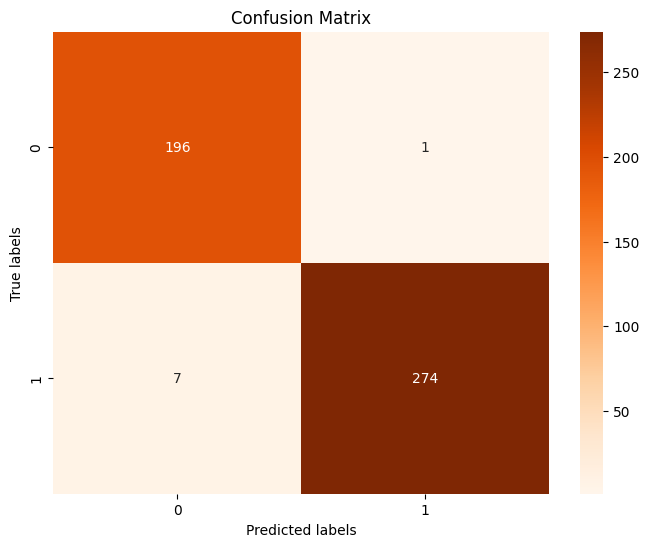

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
cm = confusion_matrix(labels, preds)

# Create a seaborn heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True)

# Add labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()


In [29]:
# Show some misclassified examples
for i in range(len(labels)):
    if labels[i] != preds[i]:
        print(tokenized_datasets["test"][i]["text"])
        print("True label:", labels[i])
        print("Predicted label:", preds[i])
        print("")

. Ausgehend von einem Mindestlohn von 12 Euro je Arbeitsstunde im Jahr 2023 beträgt die monatliche Entgeltgrenze 520 Euro. Die maximal zulässige Anzahl von Arbeitsstunden bei 520-Euro-Minijobbern liegt dauerhaft bei 43 Stunden pro Monat. Mindest-Ausbildungsvergütung steigt Für im Jahr 2023 begonnene Ausbildungsverhältnisse beträgt die monatliche Mindestausbildungsvergütung im ersten Jahr einer Berufsausbildung 620 Euro (2022: 585 Euro). Im zweiten und dritten Ausbildungsjahr steigt sie auf 732 Euro (2022: 690 Euro) bzw. 837 Euro (2022: 790 Euro) an. Höhere Ansätze für Unterkunft und Verpflegung Die Sachbezugswerte für Unterkunft und Verpflegung steigen. Der Gesamtsachbezugswert für Verpflegung wird von bisher 270 Euro auf 288 Euro im Monat erhöht. Er setzt sich zusammen aus 60 Euro für Frühstück sowie jeweils 114 Euro für Mittag- und Abendessen. Die Werte für eine Unterkunft (belegt mit einem Beschäftigten) steigen zum neuen Jahr ebenfalls von derzeit monatlich 241 Euro auf 265 Euro, b